## Library

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm
from skimage.transform import resize
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

## Init GPU

In [2]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: NVIDIA GeForce RTX 4070 SUPER is available.
cuda


In [3]:
%load_ext autoreload
%autoreload 2

## Config Info

In [4]:
# Constants
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
TEST_SIZE = 0.15
VALID_SIZE = 0.15

MAX_SLICES = 60
SHAPE = (HEIGHT, WIDTH, CHANNELS)

NUM_EPOCHS = 50

In [5]:
# Folders
DATA_DIR = '../rsna-mil-training/'
DICOM_DIR = DATA_DIR + 'rsna-mil-training'
CSV_PATH = './data_analyze/training_1000_scan_subset.csv'
patient_scan_labels = pd.read_csv(CSV_PATH)

## Data Preprocessing

In [6]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    
    bsb_img = np.stack([brain_img, subdural_img, soft_img], axis=-1)
    return bsb_img.astype(np.float16)

In [7]:
def preprocess_slice(slice, target_size=(HEIGHT, WIDTH)):
    # Check if type of slice is dicom or an empty numpy array
    if (type(slice) == np.ndarray):
        slice = resize(slice, target_size, anti_aliasing=True)
        multichannel_slice = np.stack([slice, slice, slice], axis=-1)
        return multichannel_slice.astype(np.float16)
    else:
        slice = bsb_window(slice)
        return slice.astype(np.float16)

In [8]:
def read_dicom_folder(folder_path):
    slices = []
    for filename in sorted(os.listdir(folder_path))[:MAX_SLICES]:  # Limit to MAX_SLICES
        if filename.endswith(".dcm"):
            file_path = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(file_path)
            slices.append(ds)
            
    # Sort slices by images position (z-coordinate) in ascending order
    slices = sorted(slices, key=lambda x: float(x.ImagePositionPatient[2]))
    
    # Pad with black images if necessary
    while len(slices) < MAX_SLICES:
        slices.append(np.zeros_like(slices[0].pixel_array))
    
    return slices[:MAX_SLICES]  # Ensure we return exactly MAX_SLICES

## Split Dataset

In [9]:
def split_dataset(patient_scan_labels, test_size=TEST_SIZE, val_size=VALID_SIZE, random_state=42):
    # If any of the hemorrhage indicators is 1, the label is 1, otherwise 0
    patient_scan_labels['label'] = patient_scan_labels[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any(axis=1).astype(int)

    # Extract the labels from the DataFrame
    labels = patient_scan_labels['label']

    # First, split off the test set
    train_val_labels, test_labels = train_test_split(
        patient_scan_labels, 
        test_size=test_size, 
        stratify=labels, 
        random_state=random_state
    )

    # Calculate the validation size relative to the train_val set
    val_size_adjusted = val_size / (1 - test_size)

    # Split the train_val set into train and validation sets
    train_labels, val_labels = train_test_split(
        train_val_labels, 
        test_size=val_size_adjusted, 
        stratify=train_val_labels['label'], 
        random_state=random_state
    )

    return train_labels, val_labels, test_labels

In [10]:
def process_patient_data(dicom_dir, row):
    patient_id = row['patient_id'].replace('ID_', '')
    study_instance_uid = row['study_instance_uid'].replace('ID_', '')
    
    folder_name = f"{patient_id}_{study_instance_uid}"
    folder_path = os.path.join(dicom_dir, folder_name)
    
    if os.path.exists(folder_path):
        slices = read_dicom_folder(folder_path)
        
        preprocessed_slices = [preprocess_slice(slice) for slice in slices]
        
        preprocessed_slices = np.stack(preprocessed_slices, axis=0)  # (depth, height, width, channels)
        preprocessed_slices = np.transpose(preprocessed_slices, (3, 0, 1, 2))  # (channels, depth, height, width)
        
        label = 1 if row[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any() else 0
        
        return preprocessed_slices, label
    else:
        print(f"Folder not found: {folder_path}")
        return None, None

In [11]:
class TrainDatasetGenerator(Dataset):
    """
    A custom dataset class for training data.
    """
    def __init__(self, data_dir, patient_scan_labels):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        else:
            return None, None  # Handle the case where the folder is not found

class TestDatasetGenerator(Dataset):
    """
    A custom dataset class for testing data.
    """
    def __init__(self, data_dir, patient_scan_labels):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        else:
            return None, None  # Handle the case where the folder is not found

In [12]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE, shuffle=True):
    train_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

## CNN Feature Extractor

In [13]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False).to(device)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False).to(device)

    def forward(self, x):
        batch_size, channels, _, _, _ = x.size()
    
        avg_pool = F.adaptive_avg_pool3d(x, 1).view(batch_size, channels)
        max_pool = F.adaptive_max_pool3d(x, 1).view(batch_size, channels)

        avg_out = self.fc2(F.relu(self.fc1(avg_pool)))
        max_out = self.fc2(F.relu(self.fc1(max_pool)))

        out = torch.sigmoid(avg_out + max_out).view(batch_size, channels, 1, 1, 1)
        return out * x

In [14]:
class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Apply channel attention methods
        out = ChannelAttention(out.size(1))(out)
        
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [15]:
class ResNet3D_MIL(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet3D_MIL, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv3d(3, 16, kernel_size=7, stride=(1, 2, 2), padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(16)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 32, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 32, num_blocks[3], stride=2)
        self.layer5 = self._make_layer(block, 32, num_blocks[4], stride=2)
        self.layer6 = self._make_layer(block, 32, num_blocks[5], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(32, num_classes)

        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (batch_size, channels, depth, height, width)
        batch_size, c, d, h, w = x.size()
        x = x.view(batch_size, c, d, h, w)

        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.maxpool(out)
        
        out = self.layer2(out)
        out = self.maxpool(out)

        out = self.layer3(out)
        out = self.maxpool(out)
        
        out = self.layer4(out)
        out = self.maxpool(out)
        
        out = self.layer5(out)
        out = self.maxpool(out)
        
        out = self.layer6(out)
        out = self.dropout(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        
        out = self.fc(out)

        # # MIL aggregation (max pooling over instances)
        out = torch.max(out, dim=1)[0]
        return out

def ResNet3D18_MIL():
    return ResNet3D_MIL(ResidualBlock3D, [1, 1, 1, 1, 1, 1])

In [16]:
def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, learning_rate=0.001, device='cuda'):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)
    
    best_val_accuracy = 0.0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_labels = []

        for batch_data, batch_labels in train_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(batch_data).squeeze()
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend((outputs > 0).cpu().numpy())
            train_labels.extend(batch_labels.cpu().numpy())

        train_accuracy = accuracy_score(train_labels, train_predictions)
        train_precision = precision_score(train_labels, train_predictions)
        train_recall = recall_score(train_labels, train_predictions)
        train_f1 = f1_score(train_labels, train_predictions)

        # Validation
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data = batch_data.to(device)
                batch_labels = batch_labels.float().to(device)

                outputs = model(batch_data).squeeze()
                loss = criterion(outputs, batch_labels)

                val_loss += loss.item()
                val_predictions.extend((outputs > 0).cpu().numpy())
                val_labels.extend(batch_labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_predictions)
        val_precision = precision_score(val_labels, val_predictions)
        val_recall = recall_score(val_labels, val_predictions)
        val_f1 = f1_score(val_labels, val_predictions)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()

    # Load best model
    model.load_state_dict(best_model)
    return model

In [17]:
def test_model(model, test_loader, device='cuda'):
    model = model.to(device)
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)

            outputs = model(batch_data).squeeze()
            test_predictions.extend((outputs > 0).cpu().numpy())
            test_labels.extend(batch_labels.cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_precision = precision_score(test_labels, test_predictions)
    test_recall = recall_score(test_labels, test_predictions)
    test_f1 = f1_score(test_labels, test_predictions)

    print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

    return test_accuracy, test_precision, test_recall, test_f1

In [18]:
def plot_roc_curve(model, data_loader, device):
    model.eval()
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            outputs = model(batch_data).squeeze()
            all_scores.extend(outputs.cpu().numpy())
            all_labels.extend(batch_labels.numpy())
    
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [19]:
def plot_confusion_matrix(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_data).squeeze()
            predictions = (outputs > 0).cpu().numpy()

            y_true.extend(batch_labels.cpu().numpy())
            y_pred.extend(predictions)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

Epoch 1/30
Train Loss: 67.6655, Accuracy: 0.4586, Precision: 0.4189, Recall: 0.7356, F1: 0.5338
Val Loss: 28.8228, Accuracy: 0.4133, Precision: 0.3984, Recall: 0.7778, F1: 0.5269
Epoch 2/30
Train Loss: 66.1465, Accuracy: 0.4971, Precision: 0.4473, Recall: 0.8203, F1: 0.5789
Val Loss: 26.6579, Accuracy: 0.5733, Precision: 0.4928, Recall: 0.5397, F1: 0.5152
Epoch 3/30
Train Loss: 64.5098, Accuracy: 0.5057, Precision: 0.4472, Recall: 0.7322, F1: 0.5553
Val Loss: 26.2770, Accuracy: 0.5267, Precision: 0.4333, Recall: 0.4127, F1: 0.4228
Epoch 4/30
Train Loss: 61.8472, Accuracy: 0.5257, Precision: 0.4569, Recall: 0.6644, F1: 0.5414
Val Loss: 25.4161, Accuracy: 0.5733, Precision: 0.4918, Recall: 0.4762, F1: 0.4839
Epoch 5/30
Train Loss: 58.7825, Accuracy: 0.5929, Precision: 0.5140, Recall: 0.6203, F1: 0.5622
Val Loss: 24.5245, Accuracy: 0.6533, Precision: 0.6038, Recall: 0.5079, F1: 0.5517
Epoch 6/30
Train Loss: 57.0000, Accuracy: 0.6271, Precision: 0.5531, Recall: 0.6000, F1: 0.5756
Val Loss:

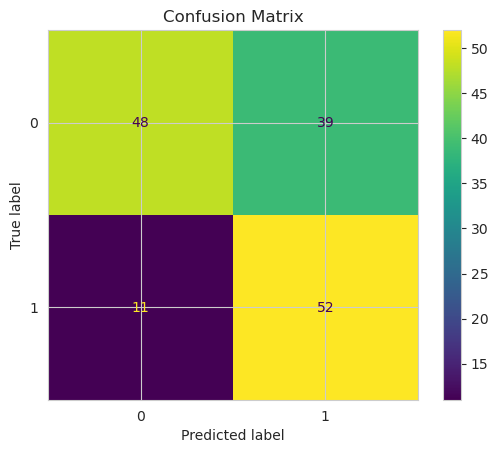

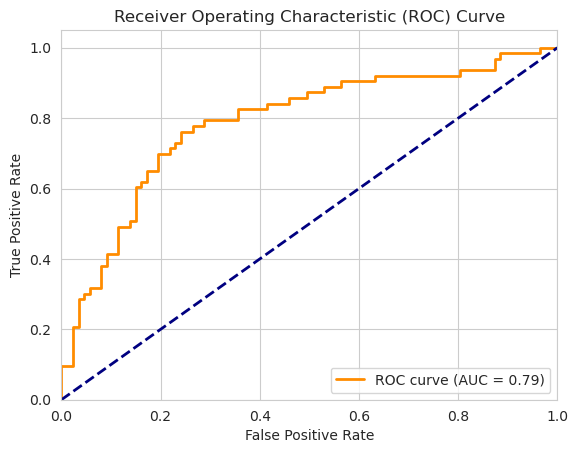

In [20]:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = ResNet3D18_MIL()
    
    train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=TEST_SIZE)
    
    train_loader = get_train_loader(DATA_DIR, train_labels, batch_size=TRAIN_BATCH_SIZE)
    val_loader = get_train_loader(DATA_DIR, val_labels, batch_size=VALID_BATCH_SIZE)
    test_loader = get_test_loader(DATA_DIR, test_labels, batch_size=TEST_BATCH_SIZE)
    
    trained_model = train_model(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001)
    
    # Plot the Confusion Matrix
    plot_confusion_matrix(trained_model, test_loader, device)
    
    # Save the model
    torch.save(trained_model.state_dict(), 'trained_model.pth')
    
    plot_roc_curve(trained_model, test_loader, device)

In [21]:
# Load the model and test it on test loader and print the results of classification to a csv 
model = ResNet3D18_MIL()
# Load the trained model
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

test_model(model, test_loader)

# Save the results to a csv file
results = []
with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.float().to(device)

        outputs = model(batch_data).squeeze()
        predictions = (outputs > 0).cpu().numpy()

        for i in range(len(predictions)):
            results.append({
                'prediction': predictions[i],
                'label': batch_labels[i].cpu().numpy()
            })

results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)
results_df.head()

/tmp/ipykernel_21877/2489041510.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_model.pth'))


Test Accuracy: 0.6067, Precision: 0.5204, Recall: 0.8095, F1: 0.6335


,prediction,label
0,True,0.0
1,True,0.0
2,True,1.0
3,True,1.0
4,True,1.0


Images shape: torch.Size([2, 3, 60, 224, 224])


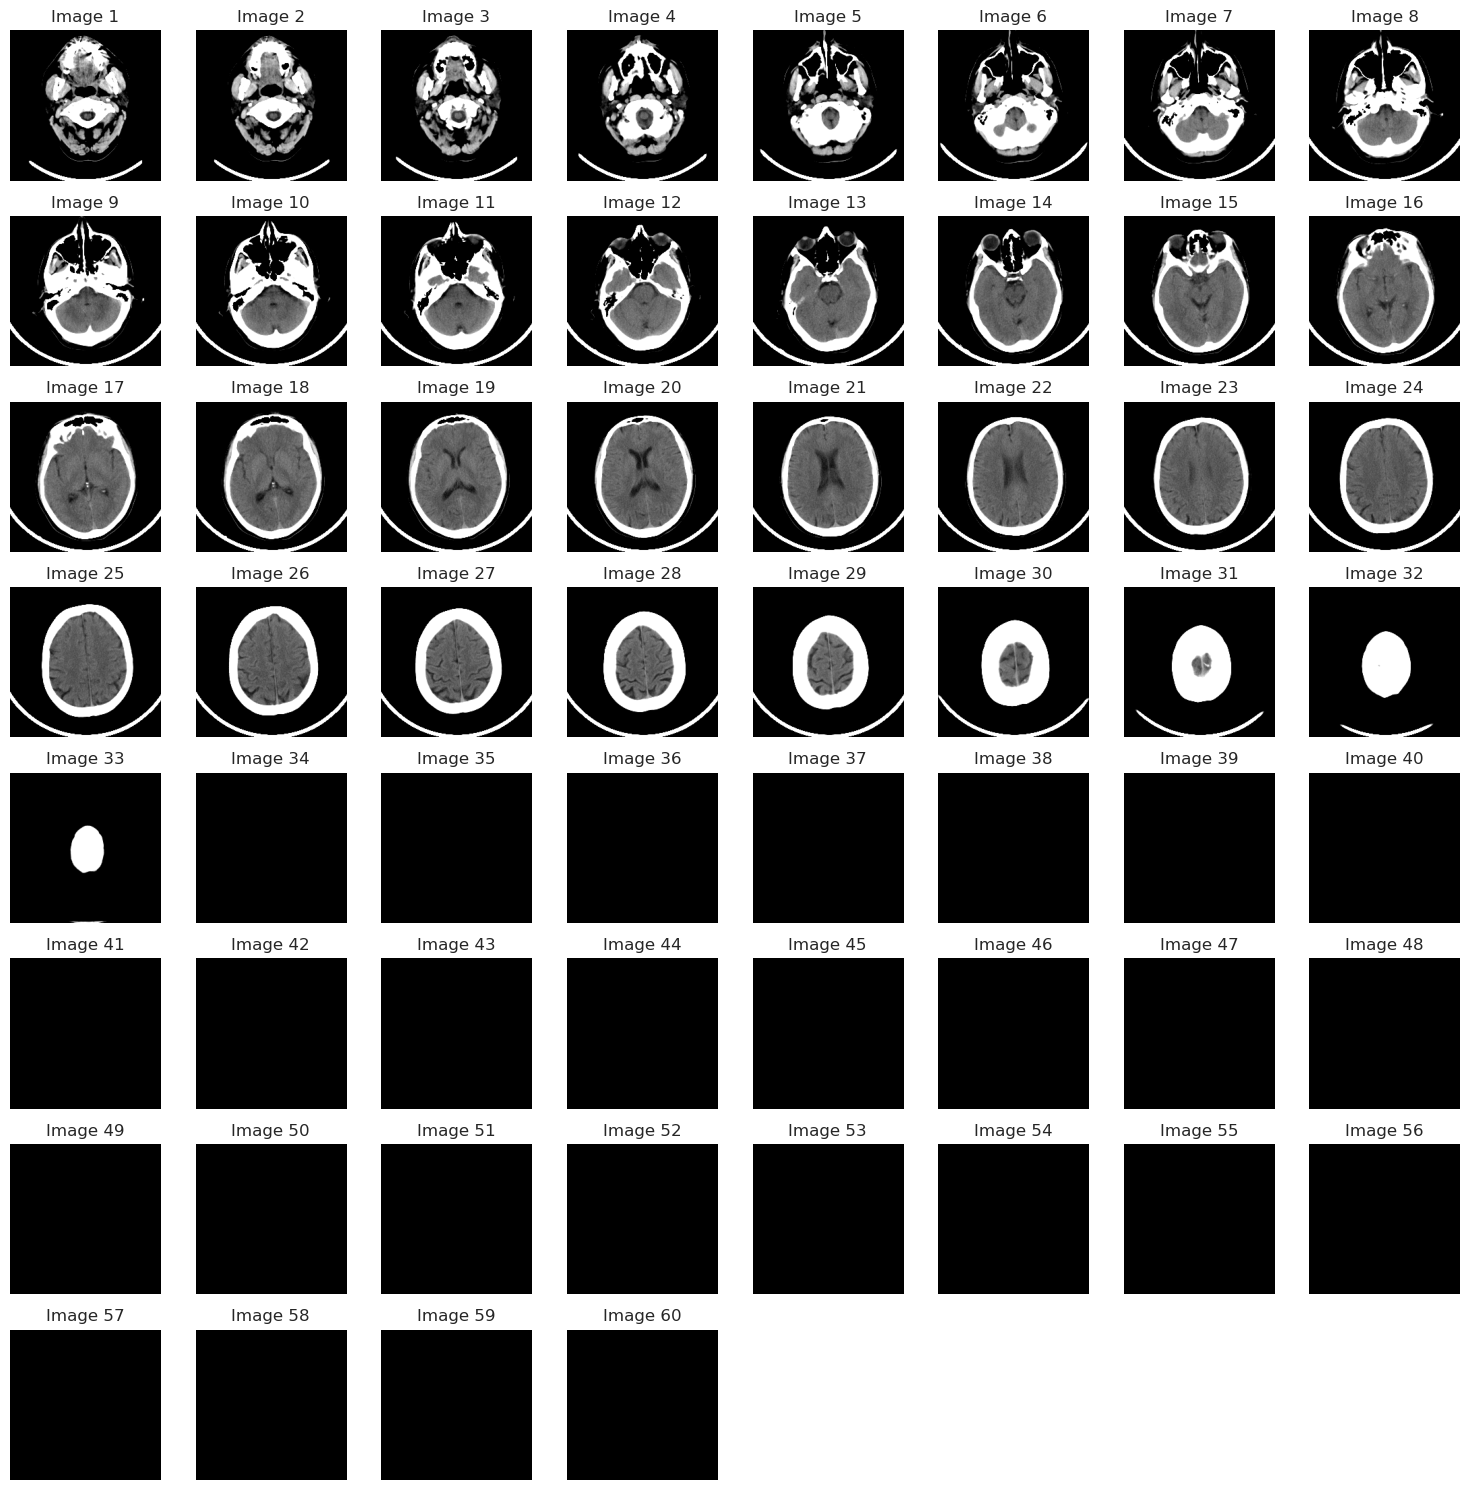

In [22]:
import matplotlib.pyplot as plt

test_loader = get_test_loader(DATA_DIR, test_labels, batch_size=2)

def plot_first_item(dataloader):
    first_item = next(iter(dataloader))
    
    print(f"Images shape: {first_item[0].size()}")
    images, labels = first_item[0]
    
    # Reshape images 
    images = images.squeeze(0)  
    images = images.permute(1, 0, 2, 3)  
    
    num_images = images.size(0)  
    images = images.numpy() 
    
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(8, 8, i + 1) 
        plt.imshow(images[i][0], cmap='gray') 
        plt.title(f'Image {i + 1}')
        plt.axis('off')
    
    plt.tight_layout() 
    plt.show()

# Gọi hàm với test_loader
plot_first_item(test_loader)